# Evaluation of Analyzers using Input Perturbations

This notebook will guide you through an example of how to evaluate analyzers via perturbing the input according to the importance that the analysis method attribute to input regions.

The input images are divided into quadratic regions that are sorted according to their importance w.r.t. to the pixel-wise saliency scores assigned by those analyzers. Then, the information content of the image is gradually destroyed by perturbation of the most important regions. The effect of this perturbation on the classifier performance is measured. This procedure is repeated several times.

We expect that the classifier performance drops quickly if important information is removed and remains largely unaffected when perturbing unimportant regions.

Thus, different analyzers can be compared by measuring how quickly their performance drops, i.e. the quicker the classifier performance drops after input perturbation w.r.t. to the prediction analysis, the better the analyzer is capable of identifying the input components responsible for the output of the model.

Similarly, several models can be compared, e.g. with random perturbations on the data, towards their resilience to noisy input data: The faster the model prediction declines with ongoing perturbations, the more susceptible the classifier is to noise.

Reference:

*[Samek et al.](http://dx.doi.org/10.1109/TNNLS.2016.2599820)*, "Evaluating the visualization of what a deep neural network has learned." *IEEE transactions on neural networks and learning systems* 28.11 (2017): 2660-2673.

-----

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb) and [Comparing methods on MNIST](mnist_method_comparison.ipynb)

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.simplefilter("ignore")

In [7]:
%matplotlib inline

import imp
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils
from innvestigate.tools.perturbate import Perturbation, PerturbationAnalysis

# Use utility libraries to focus on relevant iNNvestigate routines.
import utils as eutils
import utils.mnist as mnistutils

In [8]:
import rasterio as rio
import glob
from rasterio.plot import reshape_as_image
import geopandas as gpd
import numpy as np
from tensorflow.keras import models
from sklearn.model_selection import train_test_split

# Data
Then, the MNIST data is loaded in its entirety, formatted according to the specifications of the Keras backend.

In [9]:
import os

In [10]:
os.chdir("/home/jovyan/MSC_Thesis/MSc_Thesis_2023")

In [11]:
os.getcwd()

'/home/jovyan/MSC_Thesis/MSc_Thesis_2023'

In [12]:
training_path = "Input/sentinel/patches_256/Iowa_July_1_31/train/"
target_file_path = "Input/Target_256/concat/Iowa.shp"
ignore_patch_list = list()
x = list()
y = list()
patch_dim = (256, 256, 12)

# Model

The next part trains and evaluates a CNN.

In [13]:
img_path = 'Input/sentinel/patches_256/Iowa_July_1_31/test/Iowa_2021_july_1280-3072.tif'
file = rio.open(img_path)
img = reshape_as_image(file.read())
# file.close()
img_batch1 = np.expand_dims(img, axis=0)

img_batch = img_batch1[:,:,:,0:12]

# model_id = "aanaxs4g" # With mask
model_id = "ezb3xkqf" # No Mask
model_path = glob.glob("wandb/"+ "*"+model_id+"*" + "/files/model-best.h5")[0]
ev_gdf = gpd.read_file("Output/Evaluation/"+model_id+".shp")
# print(model_path)
cnn_model = models.load_model(model_path)

2023-03-30 17:35:13.156409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib::/usr/lib/jvm/java-11-openjdk-amd64/lib/server:/opt/hadoop/lib/native:/usr/local/lib/R/lib:/usr/local/grass82/lib
2023-03-30 17:35:13.156436: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-30 17:35:13.156449: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (81196e343232): /proc/driver/nvidia/version does not exist
2023-03-30 17:35:13.156720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow 

In [14]:
y_test_v1 = np.array(ev_gdf.query("patch_name == 'Iowa_2021_july_1280-3072'")[model_id])

In [15]:
generator = iutils.sequence.BatchSequence([img_batch, y_test_v1], batch_size=256)

In [16]:
input_range = [img_batch.min(),img_batch.max()]
test_sample = img_batch

# Perturbation Analysis

### Setup analyzer and perturbation
The perturbation analysis takes several parameters:
* `perturbation_function`: This is the method with which the pixels in the most important regions are perturbated. You can pass your own function or pass a string to select one of the predefined functions, e.g. "zeros", "mean" or "gaussian".
* `region_shape`: The shape of the regions that are considered for perturbation. In this case, we use single pixels. Regions are aggregated ("pooled") using a (customizable) aggregation function that is average pooling by default. The input image is padded such that it can be subdivided into an integer number of regions.
* `steps`: Number of perturbation steps. 
* `regions_per_step`: In each perturbation step, the `regions_per_step` regions are perturbed.

Feel free to play around with different analyzers, e.g. by selecting them from the `methods` list via `selected_methods_indices`.

In [17]:
perturbation_function = "gaussian"
region_shape = (64, 64)
steps = 15
regions_per_step = 1  # Perturbate 1 region per step

# Scale to [0, 1] range for plotting.
# def input_postprocessing(X):
#     return revert_preprocessing(X) / 255


noise_scale = (input_range[1] - input_range[0]) * 0.1
ri = input_range[0]  # reference input

# Configure analysis methods and properties
# fmt: off
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN            TITLE
    # Show input
    ("input",               {},                         mnistutils.graymap,   "Input"),
    # Random
    ("random",              {},                         mnistutils.graymap,     "Random"),
    # Function
    ("gradient",            {"postprocess": "abs"},     mnistutils.graymap,     "Gradient"),
    ("smoothgrad",
                            {"noise_scale": noise_scale, 
                             "postprocess": "square"},  mnistutils.graymap,     "SmoothGrad"),
    # Signal
    ("deconvnet",           {},                         mnistutils.bk_proj,     "Deconvnet"),
    ("guided_backprop",     {},                         mnistutils.bk_proj,     "Guided Backprop"),
    # Interaction
    ("deep_taylor.bounded", {"low": input_range[0], 
                             "high": input_range[1]},   mnistutils.heatmap,     "DeepTaylor"),
    ("input_t_gradient",    {},                         mnistutils.heatmap,     "Input * Gradient"),
    ("integrated_gradients",{"reference_inputs": ri},   mnistutils.heatmap,     "Integrated Gradients"),
    ("lrp.z",               {},                         mnistutils.heatmap,     "LRP-Z"),
    ("lrp.epsilon",         {"epsilon": 1},             mnistutils.heatmap,     "LRP-Epsilon"),
]
# fmt: on

# Select methods of your choice
selected_methods_indices = [1, 2, 3, 7]
selected_methods = [methods[i] for i in selected_methods_indices]
print(f'Using method(s) "{[method[0] for method in selected_methods]}".')

Using method(s) "['random', 'gradient', 'smoothgrad', 'input_t_gradient']".


The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [18]:
# Create model without trailing softmax
# model_wo_softmax = innvestigate.model_wo_softmax(cnn_model)

analyzers = [
    innvestigate.create_analyzer(method[0], cnn_model, **method[1])
    for method in selected_methods
]

In [19]:
for i,j in zip(selected_methods,analyzers):
    print(j)

## 1. Evaluate the model after several perturbation steps

### Setup perturbation
The perturbation analysis consists of two parts:
1. An object of the class `Perturbation` that performs the actual perturbation of input images. Here, we use (2, 2)-regions (i.e. single pixels) and add Gaussian noise to the original values of the most important pixels.
2. An object of the class `PerturbationAnalysis` that computes the analysis, performes several perturbation steps and evaluates the model performance. In each step, the 1% most important pixels are perturbed.

In [20]:
scores_selected_methods = dict()
perturbation_analyses = list()
for method, analyzer in zip(selected_methods, analyzers):
    print("Method: {}".format(method[0]))

    # Set up the perturbation analysis
    perturbation = Perturbation(
        perturbation_function, region_shape=region_shape, in_place=False
    )

    # Comment out to invert the perturbation order
    # perturbation.aggregation_function = lambda x, axis: -np.mean(x, axis=axis)

    perturbation_analysis = PerturbationAnalysis(
        analyzer,
        cnn_model,
        generator,
        perturbation,
        recompute_analysis=False,
        steps=steps,
        regions_per_step=regions_per_step,
        verbose=False,
    )

    scores = perturbation_analysis.compute_perturbation_analysis()

    # Store the scores and perturbation analyses for later use
    scores_selected_methods[method[0]] = np.array(scores)
    perturbation_analyses.append(perturbation_analysis)
    print()

Method: random

Method: gradient

Method: smoothgrad

Method: input_t_gradient



Plot the perturbation curves and compute area over the perturbation curve (AOPC)

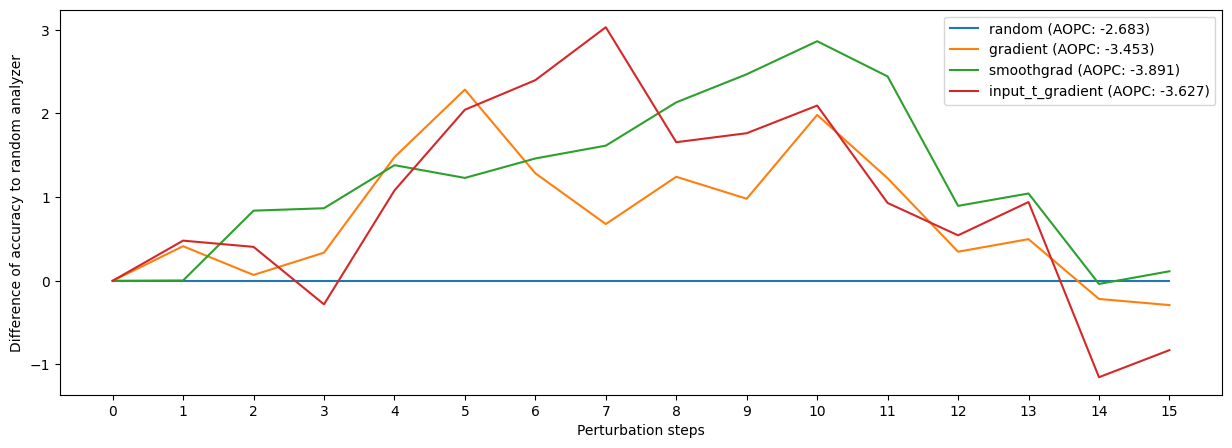

In [21]:
fig = plt.figure(figsize=(15, 5))
aopc = list()  # Area over the perturbation curve
baseline_accuracy = scores_selected_methods["random"][:, 1]
for method_name in scores_selected_methods.keys():
    scores = scores_selected_methods[method_name]
    accuracy = scores[:, 1]
    aopc.append(accuracy[0] - np.mean(accuracy))

    label = "{} (AOPC: {:.3f})".format(method_name, aopc[-1])
    plt.plot(accuracy - baseline_accuracy, label=label)

plt.xlabel("Perturbation steps")
plt.ylabel("Difference of accuracy to random analyzer")
plt.xticks(np.array(range(scores.shape[0])))
plt.legend()
plt.show()

As mentioned above, a steeper decrease shows a better identification of the relevant information.

## 2. Plot perturbed sample
Finally, we plot the perturbations on a selected test sample and show them along with the respective analyses.

In [22]:
def _reshape_to_regions(analysis):
    # aggregated_shape = tuple(
    #     (np.array(analysis.shape[2:]) / self.region_shape).astype(int)
    # )
    # regions = analysis.reshape(
    #     (
    #         analysis.shape[0],
    #         analysis.shape[1],
    #         aggregated_shape[0],
    #         self.region_shape[0],
    #         aggregated_shape[1],
    #         self.region_shape[1],
    #     )
    # )
    regions = analysis.reshape((1,1,32,8,32,8))
    return regions

def _aggregate_regions(analysis):
    # Make sure color channel has been reduced:
    assert analysis.shape[1] == 1, analysis.shape

    regions = _reshape_to_regions(analysis)
    aggregated_regions = np.mean(regions, axis=(3, 5))
    return aggregated_regions

<Figure size 640x480 with 0 Axes>

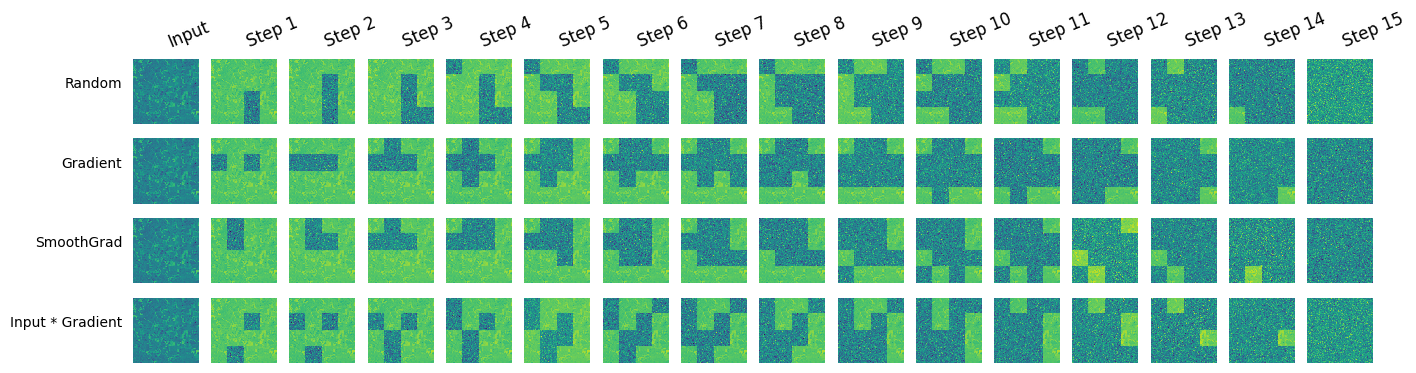

In [26]:
plt.figure()
grid, row_labels = [], []
col_labels = ["Input"] + [
    "Step {}".format(i + 1) for i in range(steps)
]
for perturbation_analysis, method in zip(perturbation_analyses, selected_methods):
    row_labels.append([method[-1]])
    samples = list()

    # Reset the perturbation_analysis
    perturbation_analysis.perturbation.num_perturbed_regions = 1

    sample = test_sample
    analysis = perturbation_analysis.analyzer.analyze(sample)   
    sub_grid = list()
    for i in range(steps + 1):
        # Plot the original image and analysis without any perturbation
        # print(i)
        if i > 0:
            perturbation_analysis.perturbation.num_perturbed_regions += (
                perturbation_analysis.regions_per_step
            )
            # Perturbate
            sample = perturbation_analysis.compute_on_batch(sample, analysis)
            aggregated_regions = perturbation_analysis.perturbation.reduce_function(
                np.moveaxis(sample, 3, 1), axis=1, keepdims=True
            )

            sub_grid.append(aggregated_regions[0][0])
        else:
            # aggregated_regions = perturbation_analysis.perturbation.reduce_function(
            #     np.moveaxis(sample, 3, 1), axis=1, keepdims=True
            # )
            sample1 = test_sample[0].sum(axis=np.argmax(np.asarray(test_sample[0].shape) == 12))
            # sample1 /= np.max(np.abs(sample1))
            # print(aggregated_regions.shape)
            sub_grid.append(sample1)
    grid.append(sub_grid)
eutils.plot_image_grid(grid, row_labels, list(), col_labels)
plt.show()

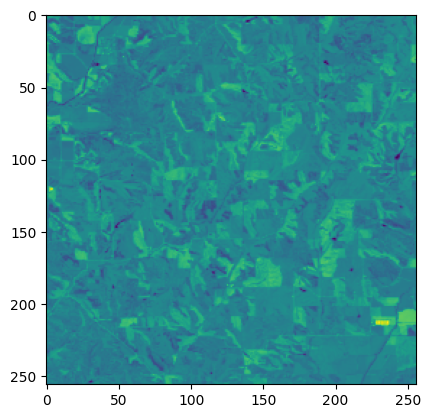

In [28]:
sample1 = test_sample[0].sum(axis=np.argmax(np.asarray(test_sample[0].shape) == 12))
plt.imshow(sample1)

In [169]:
np.array(grid[0][1]).shape

(256, 256)

In [162]:
grid1 = np.array(grid)

ValueError: could not broadcast input array from shape (256,256) into shape (256,)

In [152]:
grid1.shape

(4, 16, 256, 256)

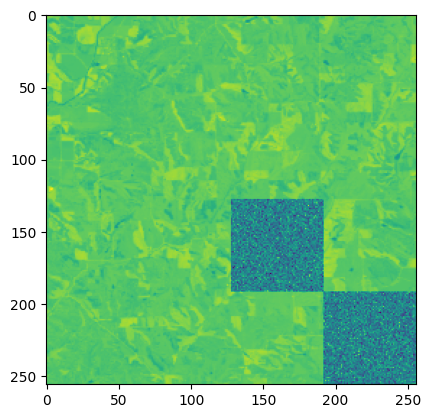

In [154]:
plt.imshow(grid1[0,1,:,:])

In [51]:
# Now plot the perturbation step by step.
plt.figure()
grid, row_labels = [], []
col_labels = ["Input", "Analysis", "Ordering"] + [
    "Step {}".format(i + 1) for i in range(steps)
]

for perturbation_analysis, method in zip(perturbation_analyses, selected_methods):
    row_labels.append([method[-1]])
    samples = list()

    # Reset the perturbation_analysis
    perturbation_analysis.perturbation.num_perturbed_regions = 1

    sample = test_sample
    analysis = perturbation_analysis.analyzer.analyze(sample)

    # Divide into regions and order them according to their analysis score
    # TODO backend channel ordering
    aggregated_regions = perturbation_analysis.perturbation.reduce_function(
        np.moveaxis(analysis, 3, 1), axis=1, keepdims=True
    )
    # aggregated_regions = perturbation_analysis.perturbation._aggregate_regions(
    #     aggregated_regions
    # )
    aggregated_regions = _aggregate_regions(
        aggregated_regions
    )
    
    ranks = perturbation_analysis.perturbation._compute_region_ordering(
        aggregated_regions
    )
    print(ranks.shape)
    # Perturbate for some steps
    for i in range(steps + 1):
        # Plot the original image and analysis without any perturbation
        if i > 0:
            perturbation_analysis.perturbation.num_perturbed_regions += (
                perturbation_analysis.regions_per_step
            )
            # Perturbate
            sample = perturbation_analysis.compute_on_batch(sample, analysis)
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        sample_to_show = mnistutils.postprocess(sample.repeat(3, axis=-1))
        analysis = mnistutils.postprocess(analysis)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        # sample_to_show = np.clip(input_postprocessing(sample_to_show), 0, 1)

        samples.append(sample_to_show[0])
    # Plot analysis
    analysis = method[2](analysis)

    # Add analysis and ranking
    samples.insert(1, analysis[0])
    samples.insert(2, -ranks[0][0])

    grid.append(samples)

(1, 1, 32, 32)
(1, 1, 32, 32)
(1, 1, 32, 32)
(1, 1, 32, 32)


<Figure size 640x480 with 0 Axes>

In [49]:
np.array(grid[0][0]).shape

(256, 256, 36)

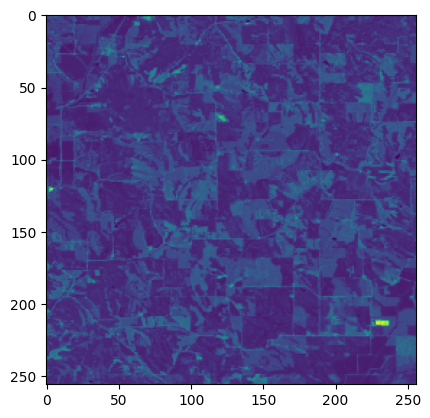

In [67]:
plt.imshow(np.array(grid[3][0][:,:,35]))